### 21BDS0340 - Abhinav Dinesh Srivatsa

In [1]:
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import time
from IPython.display import clear_output

In [2]:
BATCH_SIZE = 256
(X, y), (_, _) = tf.keras.datasets.mnist.load_data()
X = X.reshape(X.shape[0], 28, 28, 1)
X = (X - 127.5) / 127.5
X = tf.data.Dataset.from_tensor_slices(X).shuffle(len(X)).batch(BATCH_SIZE)
X

2024-10-08 18:18:34.867058: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2024-10-08 18:18:34.867084: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-10-08 18:18:34.867091: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-10-08 18:18:34.867558: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-10-08 18:18:34.868004: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


<_BatchDataset element_spec=TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float64, name=None)>

In [3]:
generator = tf.keras.Sequential([
    layers.Input((100, )),
    layers.Dense(7 * 7 * 256, use_bias=False),
    layers.BatchNormalization(),
    layers.LeakyReLU(),

    layers.Reshape((7, 7, 256)),
    layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False),
    layers.BatchNormalization(),
    layers.LeakyReLU(),

    layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False),
    layers.BatchNormalization(),
    layers.LeakyReLU(),

    layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh')
])

generator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 12544)             1254400   
                                                                 
 batch_normalization (Batch  (None, 12544)             50176     
 Normalization)                                                  
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 12544)             0         
                                                                 
 reshape (Reshape)           (None, 7, 7, 256)         0         
                                                                 
 conv2d_transpose (Conv2DTr  (None, 7, 7, 128)         819200    
 anspose)                                                        
                                                                 
 batch_normalization_1 (Bat  (None, 7, 7, 128)         5

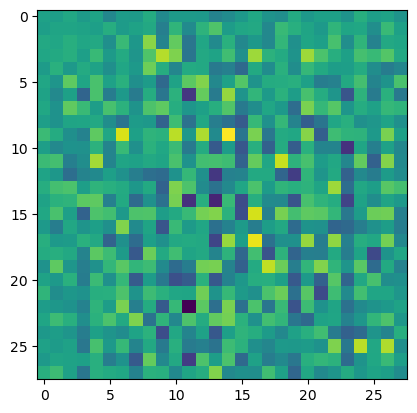

In [4]:
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)
plt.imshow(generated_image[0, :, :, 0])

In [5]:
discriminator = tf.keras.Sequential([
    layers.Input((28, 28, 1)),
    layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same'),
    layers.LeakyReLU(),
    layers.Dropout(0.3),

    layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'),
    layers.LeakyReLU(),
    layers.Dropout(0.3),

    layers.Flatten(),
    layers.Dense(1)
])

discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 14, 14, 64)        1664      
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 14, 14, 64)        0         
                                                                 
 dropout (Dropout)           (None, 14, 14, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 128)         204928    
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 7, 7, 128)         0         
                                                                 
 dropout_1 (Dropout)         (None, 7, 7, 128)         0         
                                                                 
 flatten (Flatten)           (None, 6272)             

In [6]:
decision = discriminator(generated_image)
decision

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[8.467713e-05]], dtype=float32)>

In [7]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.ones_like(fake_output), fake_output)
    return real_loss + fake_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [8]:
EXAMPLES = 16
NOISE_DIM = 100
EPOCHS = 50

gen_optimizer = tf.keras.optimizers.Adam(1e-4)
disc_optimizer = tf.keras.optimizers.Adam(1e-4)
seed = tf.random.normal([EXAMPLES, NOISE_DIM])

@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, NOISE_DIM])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

        generator_gradients = gen_tape.gradient(gen_loss, generator.trainable_variables)
        discriminator_gradients = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

        gen_optimizer.apply_gradients(zip(generator_gradients, generator.trainable_variables))
        disc_optimizer.apply_gradients(zip(discriminator_gradients, discriminator.trainable_variables))

In [9]:
def generate_and_save_images(model, epoch, test_input):
    predictions = model(test_input, training=False)

    fig = plt.figure(figsize=(4, 4))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i + 1)
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5)
        plt.axis('off')

    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

In [10]:
def train(dataset, epochs):
    for epoch in range(epochs):
        start = time.time()

        for image_batch in dataset:
            train_step(image_batch)

        clear_output(wait=True)
        generate_and_save_images(generator, epoch + 1, seed)

        print("Time for epoch {} is {} sec".format(epoch + 1, time.time() - start))

    clear_output(wait=True)
    generate_and_save_images(generator, epochs, seed)

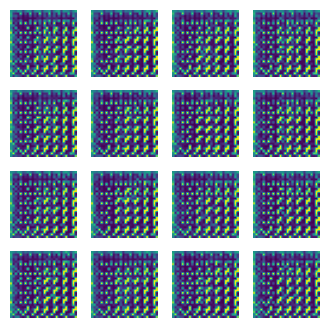

CPU times: user 3min 27s, sys: 2min 16s, total: 5min 43s
Wall time: 16min 53s


In [11]:
%%time
train(X, EPOCHS)

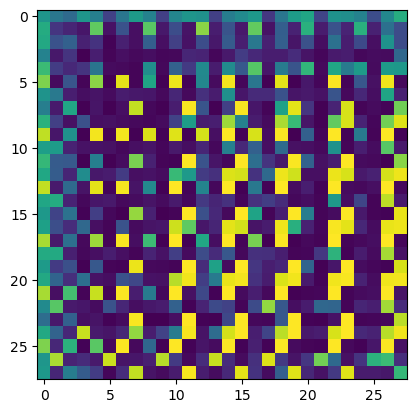

In [12]:
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)
plt.imshow(generated_image[0, :, :, 0])